## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("Data/data_saudi_used_cars.csv")

In [3]:
df.shape

(5624, 11)

In [4]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [6]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [7]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [8]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [9]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

In [10]:
df = df[df['Year']>=2000]

In [11]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [12]:
df.shape

(5364, 11)

In [13]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [14]:
df.shape

(5364, 11)

In [15]:
#df[df['Type']=='Other']

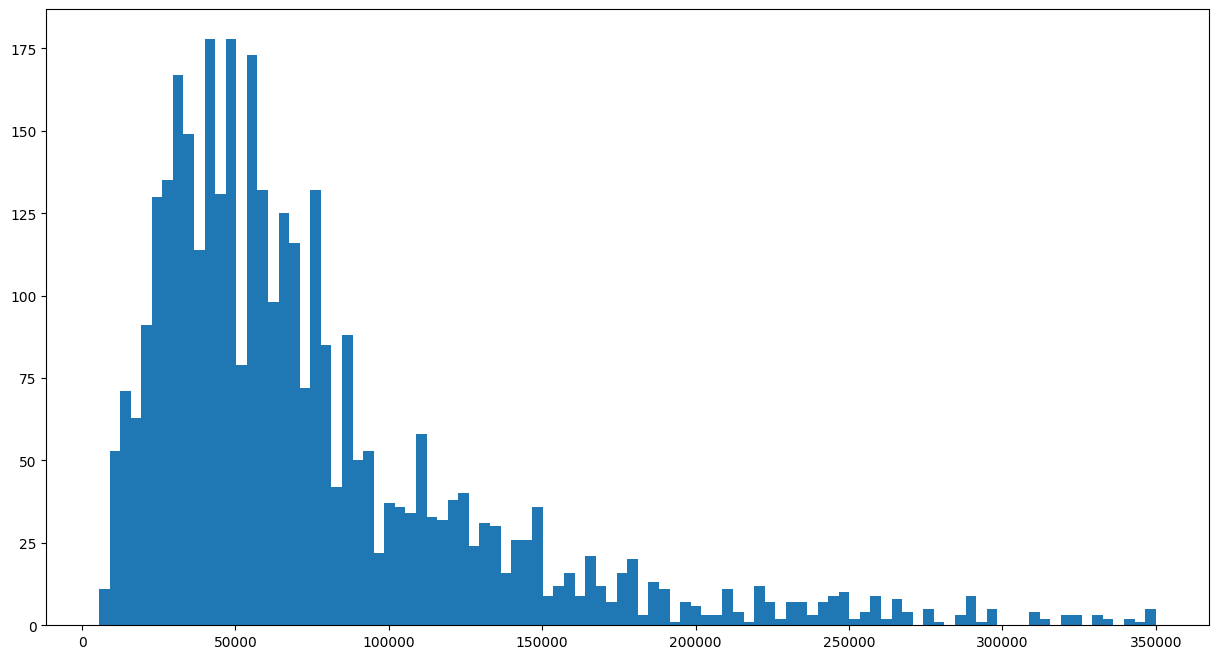

In [16]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [17]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [18]:
df.shape

(3566, 11)

In [19]:
#df[df['Mileage']<1000]

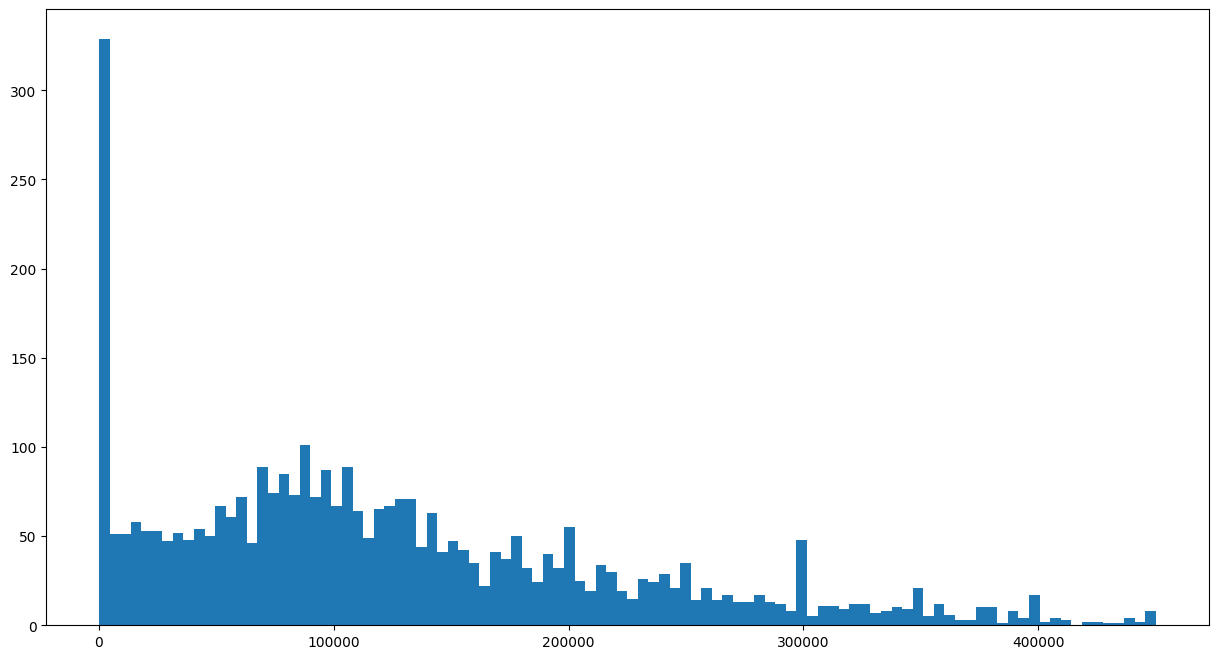

In [20]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [21]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [22]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [23]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [24]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [25]:
df.shape

(3511, 325)

In [26]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
2,2015,5.0,140000,False,260000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False


In [27]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['Price'].quantile(0.35)
p75 = df['Price'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['car_price_category'] = df['Price'].apply(categorize_price)

df.drop('Price', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['car_price_category'].value_counts())

car_price_category
Good_Price     1404
Cheap_Price    1227
High_Price      880
Name: count, dtype: int64


In [28]:
p35, p75

(46000.0, 95000.0)

In [29]:
#df['car_price_category'] 

In [30]:
encoder = LabelEncoder()
df['car_price_category_encoded'] = encoder.fit_transform(df['car_price_category'])  

#### 3. Feature selection

In [31]:
# sns.heatmap(df.corr(), annot=True);

In [32]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['car_price_category_encoded'].sort_values(ascending=False))

car_price_category_encoded    1.000000
Year                          0.407525
Engine_Size                   0.334464
Options_Full                  0.305622
Make_Mercedes                 0.225376
                                ...   
Make_Hyundai                 -0.223059
Type_Accent                  -0.237844
Options_Standard             -0.283697
Mileage                      -0.287567
Negotiable                         NaN
Name: car_price_category_encoded, Length: 325, dtype: float64


In [33]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['car_price_category_encoded']) > \
threshold]['car_price_category_encoded'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
       'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
       'car_price_category_encoded'],
      dtype='object')

In [34]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
                      'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
                      'car_price_category_encoded']

In [35]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Type_Accent,Type_Land Cruiser,Make_Hyundai,Make_Mercedes,Options_Full,Options_Standard,car_price_category_encoded
1,2014,8.0,80000,False,False,False,False,True,False,2
2,2015,5.0,140000,False,False,False,False,True,False,2
3,2015,2.4,220000,False,False,False,False,False,False,0
5,2019,2.0,25000,False,False,False,False,False,False,1
6,2012,4.8,189000,False,False,False,False,True,False,1


#### 4. Prepare train and test data

In [36]:
# Prepare data
X = df.drop(['car_price_category_encoded'], axis=1)
y = df['car_price_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

In [37]:
X.shape

(3511, 9)

## Buliding the Model

In [ ]:
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()

In [108]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],   # adjust tree depth
    'n_estimators':[35, 40, 50, 60]      # adjust num trees to build before taking the maximum voting or averages of predictions
}
grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [109]:
# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [110]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [35, 40, 50, 60]},
             scoring='f1_macro', verbose=1)

In [112]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 60}

In [113]:
best_model = grid_search.best_estimator_

## Test the Model

In [114]:
# Predict and evaluate the model
y_pred_dt = dt_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf_g = best_model.predict(X_test)

## Evaluating the Model 

In [115]:
# our benchmark model
base_model = round(df['car_price_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

39.99

1. Accuracy

In [116]:
# Evaluate train set dt model
y_pred_train_dt = dt_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_dt)
accuracy

0.9960826210826211

In [117]:
# Evaluate test set dt model
accuracy = accuracy_score(y_test, y_pred_dt)
accuracy

0.7069701280227596

In [118]:
# Evaluate train set dt model
y_pred_train_rf = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf)
accuracy

0.9960826210826211

In [119]:
# Evaluate test set rf model
accuracy = accuracy_score(y_test, y_pred_rf)
accuracy

0.7638691322901849

In [120]:
y_pred_train_rf_g = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf_g)
accuracy

0.8222934472934473

In [121]:
accuracy = accuracy_score(y_test, y_pred_rf_g)
accuracy

0.802275960170697

In [122]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_g)
conf_matrix

array([[186,  55,   2],
       [ 30, 223,  27],
       [  1,  24, 155]], dtype=int64)

In [123]:
print("Train classification report for best rf:")
print(f' {classification_report(y_train, y_pred_train_rf_g, labels=list(best_model.classes_))}')
print(" Test classification report for best rf: ")
print(f'{classification_report(y_test, y_pred_rf_g, labels=list(best_model.classes_))}')

Train classification report for best rf:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       984
           1       0.76      0.84      0.79      1124
           2       0.87      0.82      0.84       700

    accuracy                           0.82      2808
   macro avg       0.83      0.82      0.83      2808
weighted avg       0.83      0.82      0.82      2808

 Test classification report for best rf: 
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       243
           1       0.74      0.80      0.77       280
           2       0.84      0.86      0.85       180

    accuracy                           0.80       703
   macro avg       0.81      0.81      0.81       703
weighted avg       0.81      0.80      0.80       703



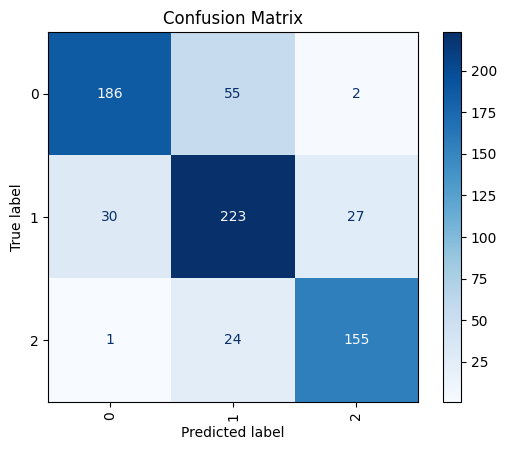

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_g,
                                        display_labels=best_model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [103]:
# Calculate Precision
precision = precision_score(y_test, y_pred_rf_g, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.80


In [104]:
# Calculate Recall
recall = recall_score(y_test, y_pred_rf_g, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.80


In [105]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred_rf_g, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.80


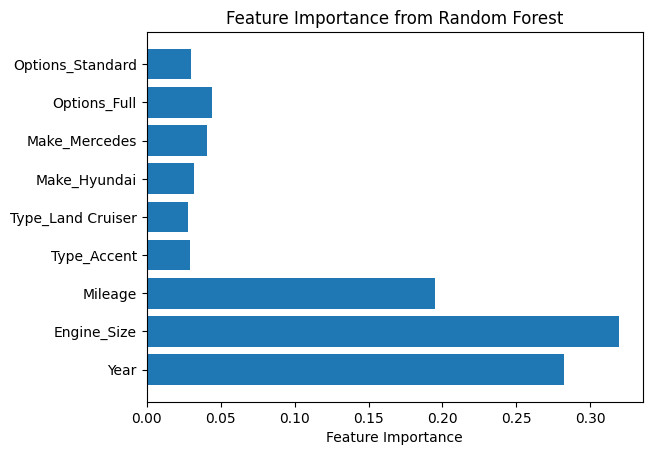

In [106]:
# Feature importance from Random Forest
feature_importances = best_model.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()